In [ ]:
#@ Downloading the Libraries and Dependencies:
import sys, os, tarfile, urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#@ Visualization Dependencies:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."
ID = "California Housing"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#@ Ignoring the Warnings:
import warnings
warnings.filterwarnings(action="ignore", message="^ internal")
import IPython

In [ ]:
#@ Getting the Data:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()                                                           # Initializing the Function.

#@ Getting the Data:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#@ Inspecting the Data:
housing = load_housing_data()
housing.head(7)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
print(housing["ocean_proximity"].value_counts())          # Inspecting the Categorical Attribute.
print("\n")
IPython.display.display(housing.describe())               # Inspecting the Numerical Attributes.

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving Figure Histogram Plots


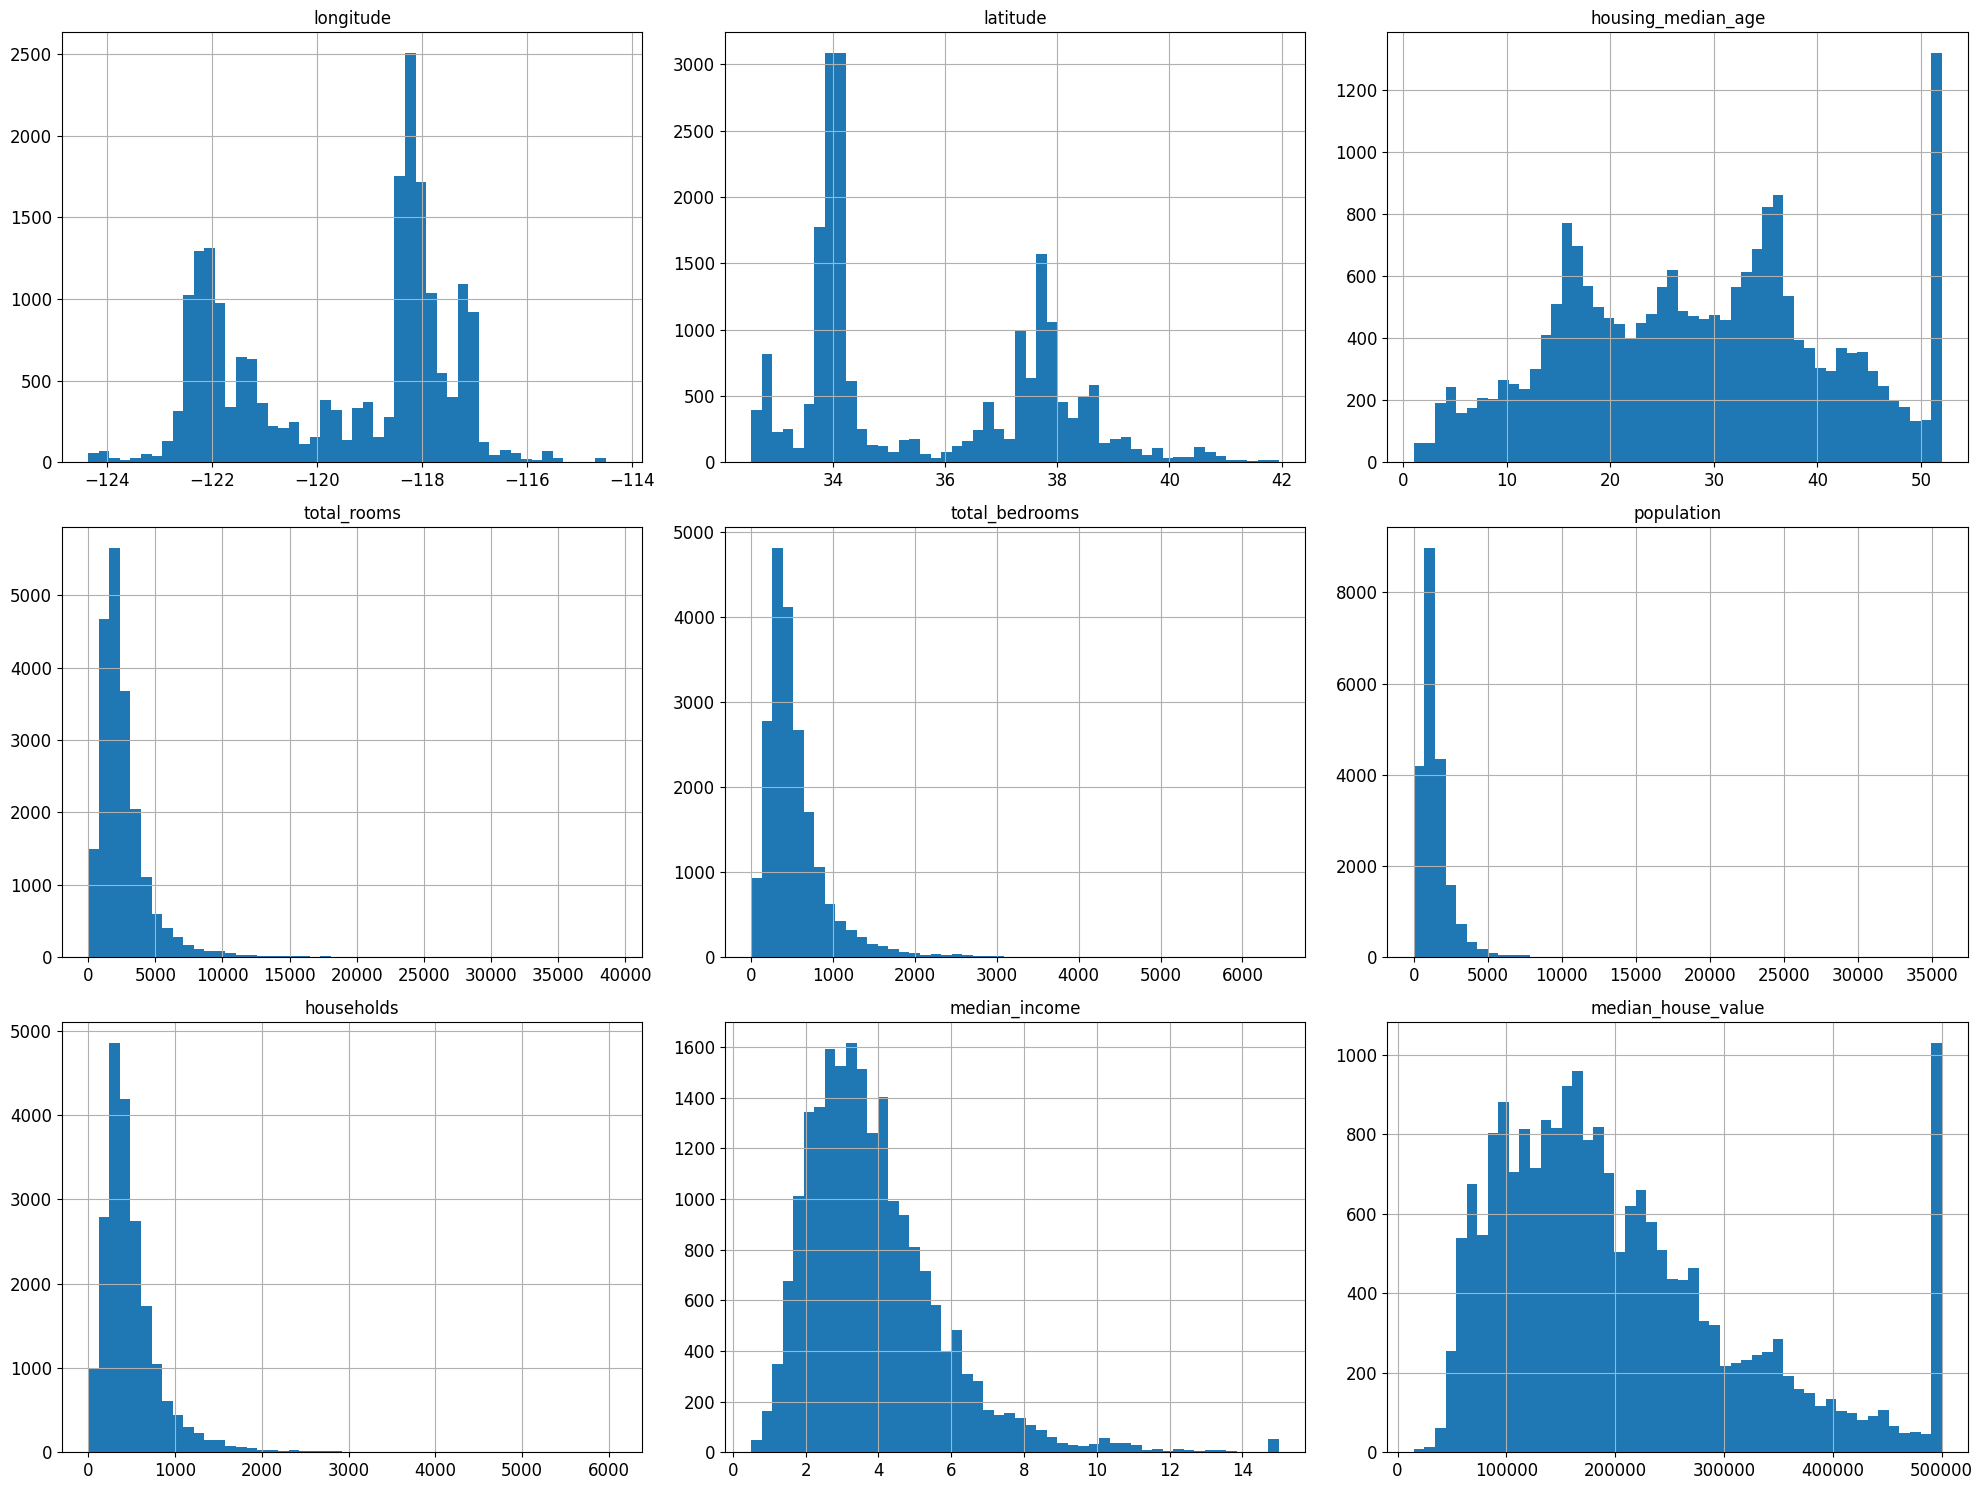

In [ ]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
save_fig("Histogram Plots")
plt.show()

In [ ]:
#@ Splitting the Dataset:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)

#@ Inspecting the Dataset:
print(f"Training set: {len(train_set)}")                                             # Number of Training Dataset.
print(f"\nTesting set: {len(test_set)}")                                             # Number of Testing Dataset.
IPython.display.display(train_set.head(3))
print("\n")
IPython.display.display(test_set.head(3))

Training set: 16512

Testing set: 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20025,-119.05,36.07,21.0,2472.0,523.0,1238.0,504.0,1.7756,62900.0,INLAND
10772,-117.89,33.66,32.0,2736.0,550.0,1279.0,534.0,5.5422,253100.0,<1H OCEAN
16691,-120.61,35.13,16.0,3431.0,721.0,1777.0,701.0,2.7301,190400.0,<1H OCEAN


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2734,-115.56,32.78,34.0,2856.0,555.0,1627.0,522.0,3.2083,76200.0,INLAND
9087,-118.17,34.66,9.0,1561.0,253.0,731.0,233.0,5.7049,173200.0,INLAND
15789,-122.40,37.78,52.0,464.0,202.0,286.0,148.0,1.6125,112500.0,NEAR BAY


<Axes: >

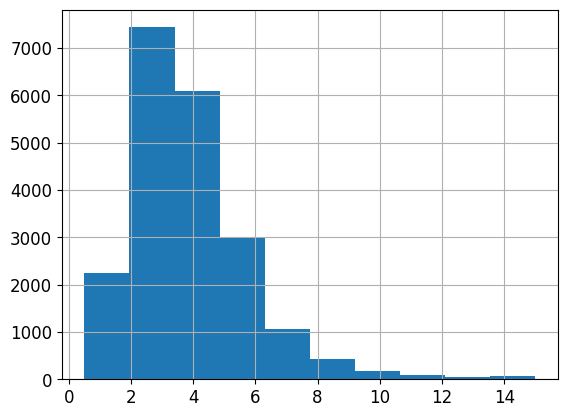

In [ ]:
#@ Inspecting the median income attribute:
housing["median_income"].hist()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64




<Axes: >

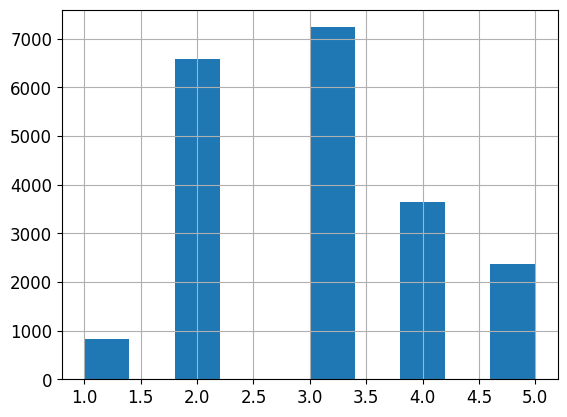

In [ ]:
#@ Creating the Income Categories:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

#@ Inspecting the Income Categories:
print(housing["income_cat"].value_counts())
print("\n")
housing["income_cat"].hist()

In [ ]:
#@ Stratified Sampling based on Income Category:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

#@ Inspecting the Sampling:
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))            # Income Category Proportions in Test set.
print("\n")
print(housing["income_cat"].value_counts() / len(housing))                          # Income Category Proportions in Full Dataset.

#@ Comparing the Proportions:
def income_cat_propotions(data):
  return data["income_cat"].value_counts() / len(data)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=11)     # Splitting the Dataset.
compare_props = pd.DataFrame({
    "Overall": income_cat_propotions(housing),                                      # Full Dataset.
    "Stratified": income_cat_propotions(strat_test_set),                            # Stratified Sampling Dataset.
    "Random": income_cat_propotions(test_set)                                       # Random Smapling Dataset.
}).sort_index()
compare_props["Random % Error"] = 100 * compare_props["Random"] / compare_props["Overall"] -100
compare_props["Stratified % Error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] -100

#@ Inspecting the Proportions:
print("\n")
IPython.display.display(compare_props)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64




,Overall,Stratified,Random,Random % Error,Stratified % Error
income_cat,,,,,
1,0.039826,0.039971,0.032946,-17.274939,0.364964
2,0.318847,0.318798,0.312984,-1.838626,-0.015195
3,0.350581,0.350533,0.353440,0.815368,-0.013820
4,0.176308,0.176357,0.184835,4.836494,0.027480
5,0.114438,0.114341,0.115795,1.185436,-0.084674


In [ ]:
#@ Removing the Income Cat from the Data:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

Saving Figure Geographical Plot
Saving Figure Geographical Plots


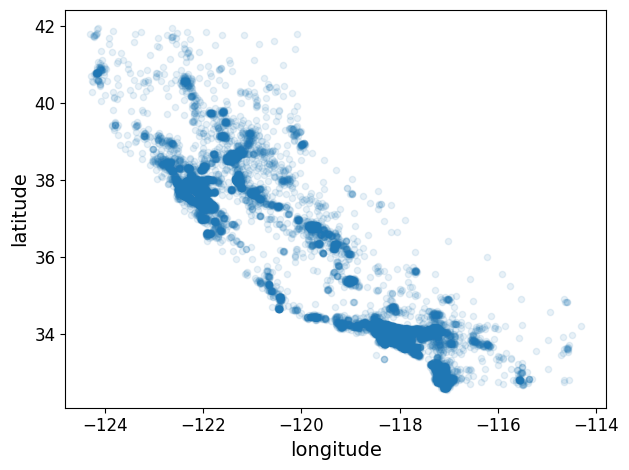

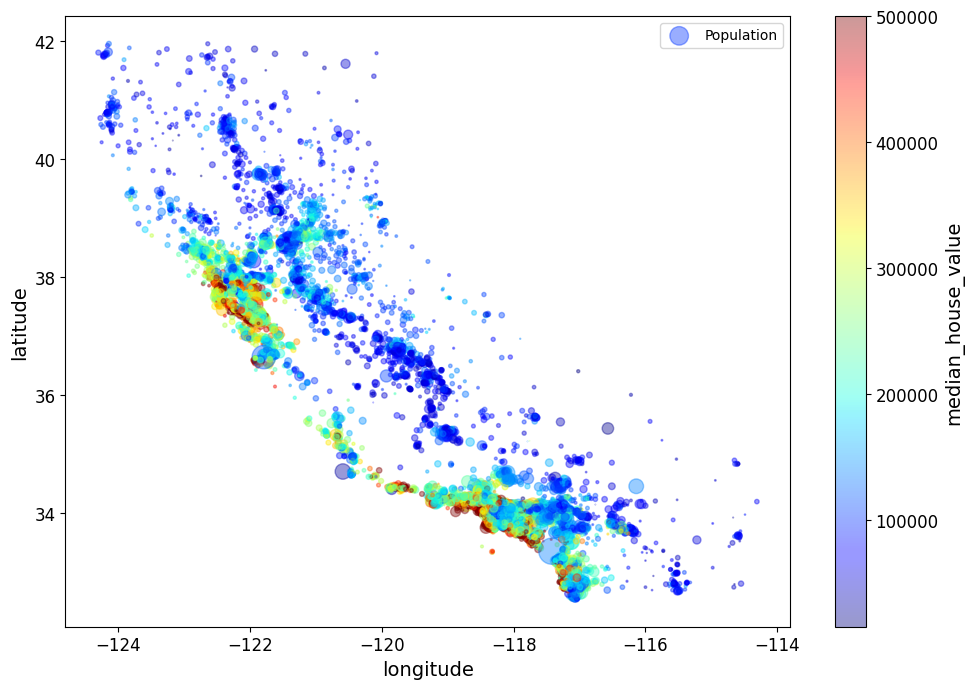

In [ ]:
#@ Creating the copy of the Training set:
housing = strat_train_set.copy()

#@ Visualizing the Geographical Data:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("Geographical Plot")
#@ Visualizing the Housing Prices:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("Geographical Plots")

In [ ]:

print(housing.dtypes)
housing["ocean_proximity"] = housing["ocean_proximity"].astype("category").cat.codes
#@ Correlations:
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object
median_house_value    1.000000
median_income         0.687829
total_rooms           0.136194
housing_median_age    0.100138
ocean_proximity       0.086325
households            0.065931
total_bedrooms        0.050729
population           -0.026367
longitude            -0.043233
latitude             -0.147857
Name: median_house_value, dtype: float64


Saving Figure Correlations


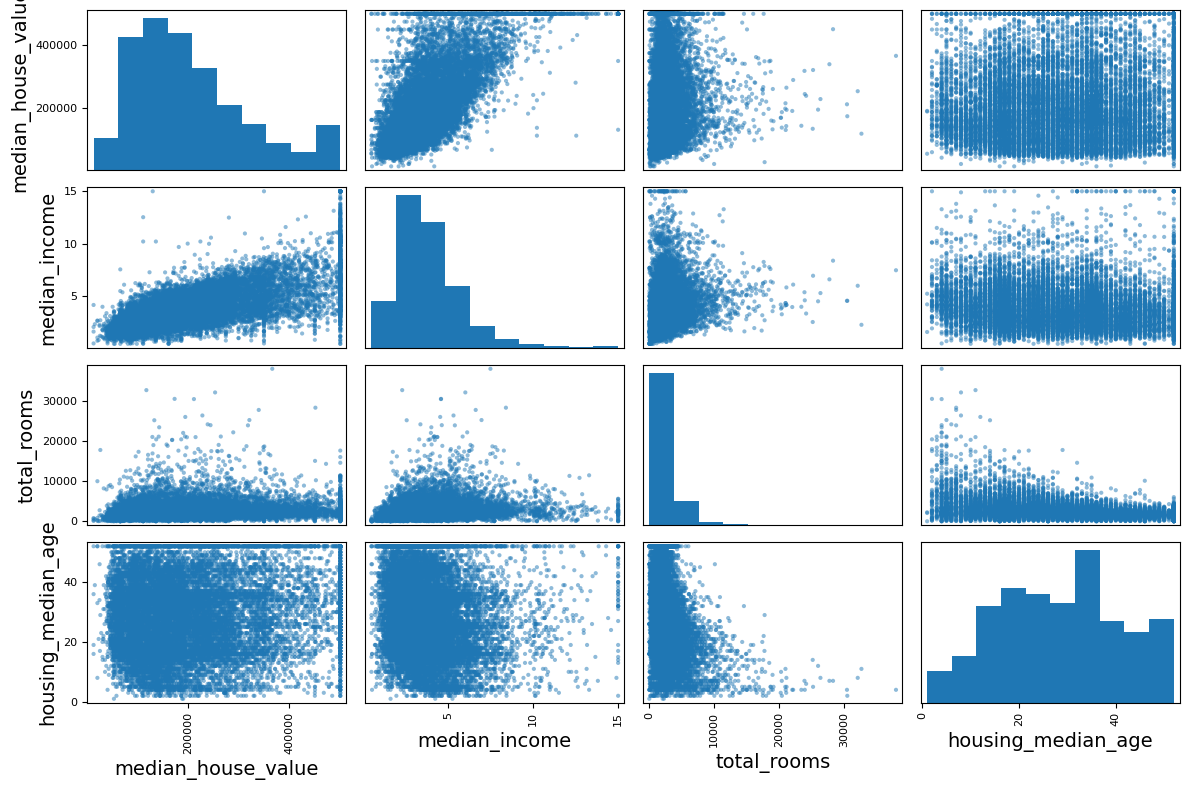

In [ ]:
#@ Correlations using Scatter matrix:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("Correlations")

Saving Figure Median House value vs Median Income


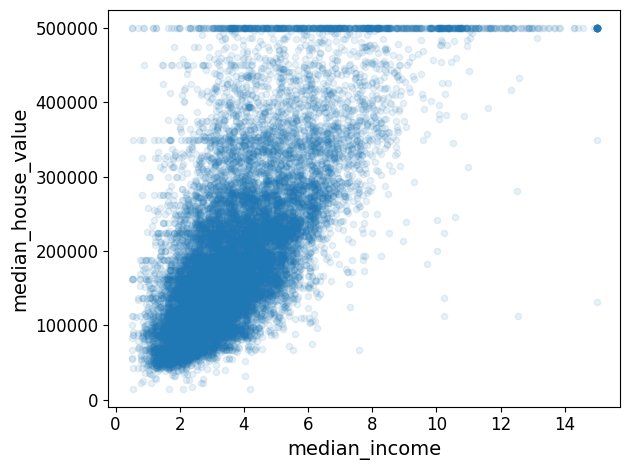

In [ ]:
#@ Correlations of Median House Value with Median Income.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
save_fig("Median House value vs Median Income")

In [ ]:
#@ Attribute Combinations:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]   # Rooms per Household.
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] # Bedrooms per Room.
housing["population_per_household"] = housing["population"]/housing["households"] # Populations per Household.

#@ Inspecting the Correlations:
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

#@ Inspecting the Data:
print("\n")
housing.describe()

median_house_value          1.000000
median_income               0.687829
rooms_per_household         0.172937
total_rooms                 0.136194
housing_median_age          0.100138
ocean_proximity             0.086325
households                  0.065931
total_bedrooms              0.050729
population_per_household   -0.022292
population                 -0.026367
longitude                  -0.043233
latitude                   -0.147857
bedrooms_per_room          -0.260075
Name: median_house_value, dtype: float64




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16343.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16343.000000,16512.000000
mean,-119.577814,35.642869,28.623123,2621.339995,534.391727,1419.420179,496.418060,3.869816,206525.148740,1.166727,5.419483,0.212982,3.111527
std,2.004481,2.141427,12.581950,2147.395386,413.642527,1126.132770,375.015774,1.902213,115370.175603,1.419301,2.150152,0.057695,11.604931
min,-124.300000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.888889,0.100000,0.750000
25%,-121.800000,33.940000,18.000000,1445.000000,296.000000,792.000000,280.000000,2.562175,119400.000000,0.000000,4.442941,0.175460,2.429049
50%,-118.500000,34.260000,29.000000,2125.000000,434.000000,1166.000000,409.000000,3.531300,179200.000000,1.000000,5.227585,0.203221,2.819702
75%,-118.010000,37.720000,37.000000,3136.000000,644.000000,1716.000000,601.000000,4.750000,264600.000000,1.000000,6.056917,0.239637,3.286276
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000,62.422222,1.000000,1243.333333


In [ ]:
#@ Preparing the Data for Machine Learning:
housing = strat_train_set.drop("median_house_value", axis=1)                   # Drop the labels from Training set.
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
#@ Working on missing values:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
IPython.display.display(sample_incomplete_rows)                                             # Inspecting the missing values.
sample_incomplete_rows.dropna(subset=["total_bedrooms"])                                    # Getting rid of corresponding districts.
sample_incomplete_rows.drop("total_bedrooms", axis=1)                                       # Getting rid of whole attribute.
median = housing["total_bedrooms"].median()                                                 # Calculating the median.
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)                       # Imputing the median value.
print("\n")
IPython.display.display(sample_incomplete_rows)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4600,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,<1H OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,NEAR OCEAN
17928,-121.97,37.34,33.0,3162.0,NaN,1553.0,686.0,3.6682,<1H OCEAN
7330,-118.17,33.98,41.0,756.0,NaN,873.0,212.0,2.7321,<1H OCEAN
4043,-118.50,34.17,37.0,880.0,NaN,369.0,155.0,4.1429,<1H OCEAN


<ipython-input-28-095034803767>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)                       # Imputing the median value.


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4600,-118.27,34.04,13.0,1784.0,434.0,2158.0,682.0,1.7038,<1H OCEAN
20268,-119.18,34.19,19.0,2393.0,434.0,1938.0,762.0,1.6953,NEAR OCEAN
17928,-121.97,37.34,33.0,3162.0,434.0,1553.0,686.0,3.6682,<1H OCEAN
7330,-118.17,33.98,41.0,756.0,434.0,873.0,212.0,2.7321,<1H OCEAN
4043,-118.50,34.17,37.0,880.0,434.0,369.0,155.0,4.1429,<1H OCEAN


In [ ]:
#@ Missing Data:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")                               # Instantiating the Imputer.
housing_num = housing.drop("ocean_proximity", axis=1)                    # Removing the Text Attribute.
imputer.fit(housing_num)                                                 # Fitting the Imputer instance to the Training Data.
print(imputer.statistics_)                                               # Inspecting the values.
print(housing_num.median().values)                                       # Inspecting the median values.
X = imputer.transform(housing_num)                                       # Transforming the Training set with trained imputer.
housing_imputed = pd.DataFrame(X, columns=housing_num.columns)           # Creating the DataFrame with numpy arrays.
print("\n")
IPython.display.display(housing_imputed.head())

[-118.5      34.26     29.     2125.      434.     1166.      409.
    3.5313]
[-118.5      34.26     29.     2125.      434.     1166.      409.
    3.5313]




,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-117.46,34.09,8.0,4711.0,963.0,3310.0,988.0,3.5488
1,-116.94,32.78,17.0,13559.0,2656.0,6990.0,2533.0,3.4340
2,-118.27,34.04,13.0,1784.0,434.0,2158.0,682.0,1.7038
3,-119.75,36.75,50.0,1515.0,294.0,852.0,297.0,1.9955
4,-122.42,37.77,52.0,1086.0,349.0,589.0,361.0,2.5186


In [ ]:
#@ Handling Text and Categorical Attributes:
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head())                                                  # Inspecting the Categorical attribute.
ordinal_encoder = OrdinalEncoder()                                         # Instantiating the Encoder.
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)           # Encoding the Text.
IPython.display.display(housing_cat_encoded[:10])                          # Inspecting the Encoded Text.
print("\n")
print(ordinal_encoder.categories_)

      ocean_proximity
13406          INLAND
15049       <1H OCEAN
4600        <1H OCEAN
2109           INLAND
15760        NEAR BAY


array([[1.],
       [0.],
       [0.],
       [1.],
       [3.],
       [0.],
       [1.],
       [4.],
       [0.],
       [1.]])



[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [ ]:
#@ Custom Transformers:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
attribute_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)                          # Instantiating the Transformer.
housing_extra_attrs = attribute_adder.transform(housing.values)

#@ Getting the columns indices:
col_names = ["total_rooms", "total_bedrooms", "population", "households"]
rooms_ix, bedrooms_ix, population_ix, households_ix = [
  housing.columns.get_loc(c) for c in col_names
]

#@ Creating the DataFrame:
housing_extra_attrs = pd.DataFrame(
    housing_extra_attrs,
    columns = list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index = housing.index
)
#@ Inspecting the DataFrame:
housing_extra_attrs.head(7)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
13406,-117.46,34.09,8.0,4711.0,963.0,3310.0,988.0,3.5488,INLAND,4.768219,3.350202
15049,-116.94,32.78,17.0,13559.0,2656.0,6990.0,2533.0,3.434,<1H OCEAN,5.352941,2.759574
4600,-118.27,34.04,13.0,1784.0,NaN,2158.0,682.0,1.7038,<1H OCEAN,2.615836,3.164223
2109,-119.75,36.75,50.0,1515.0,294.0,852.0,297.0,1.9955,INLAND,5.10101,2.868687
15760,-122.42,37.77,52.0,1086.0,349.0,589.0,361.0,2.5186,NEAR BAY,3.00831,1.631579
3917,-118.53,34.19,32.0,2618.0,692.0,1961.0,633.0,2.625,<1H OCEAN,4.135861,3.097946
11965,-117.42,34.02,9.0,5455.0,882.0,3015.0,858.0,4.2321,INLAND,6.357809,3.513986


In [ ]:
#@ Transformation Pipelines:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#@ Pipeline for Numerical attributes:
num_pipeline = Pipeline([
                         ("imputer", SimpleImputer(strategy="median")),
                         ("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)
#@ Inspecting the Transformations:
housing_num_tr[:10]

array([[ 1.05657146e+00, -7.25178033e-01, -1.63915343e+00,
         9.73143231e-01,  1.04373828e+00,  1.67887582e+00,
         1.31086973e+00, -1.68764378e-01, -3.02901311e-01,
         2.05673820e-02, -1.41894598e-01],
       [ 1.31599804e+00, -1.33693816e+00, -9.23821365e-01,
         5.09360842e+00,  5.15663809e+00,  4.94679549e+00,
         5.43082120e+00, -2.29116963e-01, -3.09483779e-02,
        -3.03287984e-02, -2.71960587e-01],
       [ 6.52464678e-01, -7.48527656e-01, -1.24174673e+00,
        -3.89944655e-01, -2.41391070e-01,  6.55874872e-01,
         4.94879344e-01, -1.13871664e+00, -1.30396896e+00,
         4.54098948e-03,  4.50582000e-01],
       [-8.59032678e-02,  5.17021913e-01,  1.69906288e+00,
        -5.15216483e-01, -5.81500917e-01, -5.03881405e-01,
        -5.31775228e-01, -9.85364294e-01, -1.48120864e-01,
        -2.09261970e-02, -2.99790279e-01],
       [-1.41795895e+00,  9.93354223e-01,  1.85802556e+00,
        -7.14999436e-01, -4.47886334e-01, -7.37431099e-01,
  

In [ ]:
#@ Implementation of ColumnTransformer:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)                          # List of numerical attributes.
cat_attribs = ["ocean_proximity"]                        # List of categorical attributes.
pipeline = ColumnTransformer([
                              ("num", num_pipeline, num_attribs),
                              ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = pipeline.fit_transform(housing)

#@ Inspecting the Transformers:
print(housing_prepared[:10])
print(housing_prepared.shape)

[[ 1.05657146e+00 -7.25178033e-01 -1.63915343e+00  9.73143231e-01
   1.04373828e+00  1.67887582e+00  1.31086973e+00 -1.68764378e-01
  -3.02901311e-01  2.05673820e-02 -1.41894598e-01  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.31599804e+00 -1.33693816e+00 -9.23821365e-01  5.09360842e+00
   5.15663809e+00  4.94679549e+00  5.43082120e+00 -2.29116963e-01
  -3.09483779e-02 -3.03287984e-02 -2.71960587e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.52464678e-01 -7.48527656e-01 -1.24174673e+00 -3.89944655e-01
  -2.41391070e-01  6.55874872e-01  4.94879344e-01 -1.13871664e+00
  -1.30396896e+00  4.54098948e-03  4.50582000e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.59032678e-02  5.17021913e-01  1.69906288e+00 -5.15216483e-01
  -5.81500917e-01 -5.03881405e-01 -5.31775228e-01 -9.85364294e-01
  -1.48120864e-01 -2.09261970e-02 -2.99790279e-01  0.00000000e+00
   1.00

In [ ]:
#@ Training the Model:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()                                              # Instantiating the Model.
lin_reg.fit(housing_prepared, housing_labels)                             # Training the Linear Model.

#@ Inspecting the Model on few Instances:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_prepared = pipeline.transform(some_data)
print(f"Predictions: {lin_reg.predict(some_prepared)}")                   # Inspecting the Predictions.
print(f"Labels: {list(some_labels)}")

#@ Inspecting the Errors:
print("\n")
from sklearn.metrics import mean_squared_error, mean_absolute_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)                                                            # Inspecting the root mean squared error.
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print(lin_mae)

Predictions: [115089.03028686 237180.7734814  111454.03384564  97637.75245284
 231436.2555599 ]
Labels: [101600.0, 193200.0, 118100.0, 54200.0, 250000.0]


68374.47729810608
49336.18361042538


In [ ]:
#@ Implementation of Decision Trees:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=11)                      # Instantiating the Model.
tree_reg.fit(housing_prepared, housing_labels)                         # Training the Model.
housing_predictions = tree_reg.predict(housing_prepared)               # Making predictions.
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [ ]:
#@ Implementation of Cross Validation with Decision Trees:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

#@ Inspecting the Result:
def display_scores(scores):
  print(f"Scores: {scores}")
  print(f"Mean: {scores.mean()}")
  print(f"Standard Deviation: {scores.std()}")
display_scores(tree_rmse_scores)                                                   # Inspecting the scores.

#@ Implementation of Cross Validation with Linear Regression:
print("\n")
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70023.4342306  72503.92384914 70562.31133473 72198.84994616
 70659.15427702 70465.9078777  74384.0725336  69449.38378315
 72456.11017325 72975.96313637]
Mean: 71567.91111417107
Standard Deviation: 1479.9163756995156


Scores: [68933.8840818  63912.44545425 65182.47220495 69076.77351892
 68509.63409608 71268.19351746 72110.36234621 69043.61576356
 72588.71311982 67289.31142905]
Mean: 68791.54055320886
Standard Deviation: 2662.689915391289


In [ ]:
#@ Random Forest Regressor:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=160, min_samples_leaf=3,                            # Instantiating the Model.
                                   n_jobs=-1, random_state=11)
forest_reg.fit(housing_prepared, housing_labels)                                                    # Training the Model.
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)                                # Calculating mean squared error.
forest_rmse = np.sqrt(forest_mse)                                                                   # Calculating root mean squard error.
print(forest_rmse)
print("\n")
#@ Random Forest Regressor with Cross Validation:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,                       # Random Forest with Cross Validation.
                                scoring="neg_mean_squared_error", cv=10)
forest_scores_rmse = np.sqrt(-forest_scores)
display_scores(forest_scores_rmse)

27641.16479672759


Scores: [49818.10089606 48236.66518442 47609.48010218 49400.35060767
 52546.47796936 51136.40321791 50097.58104821 50411.66207052
 51351.1496815  50500.07884491]
Mean: 50110.79496227294
Standard Deviation: 1382.9128986003948


In [ ]:
#@ Saving the Random Forest Model:
#import joblibfrom sklearn.externals import joblib
import joblib
joblib.dump(forest_reg, "ForestModel.pkl")

['ForestModel.pkl']

In [ ]:
#@ Grid Search and Tuning the Model:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {"n_estimators":[30, 60, 90, 120], "max_features":[2, 3, 4]},
              {"bootstrap":[False], "n_estimators":[90, 120], "max_features":[2, 3, 4]}]
forest_reg = RandomForestRegressor(random_state=11)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

#@ Inspecting the Result:
print(grid_search.best_params_)
print("\n")
print(grid_search.best_estimator_)
print("\n")

#@ Inspecting the Scores:
cvresults = grid_search.cv_results_
for mean_score, params in zip(cvresults["mean_test_score"], cvresults["params"]):
  print(np.sqrt(-mean_score), params)
print("\n")
IPython.display.display(pd.DataFrame(grid_search.cv_results_))

{'bootstrap': False, 'max_features': 4, 'n_estimators': 120}


RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=120,
                      random_state=11)


52624.683583549704 {'max_features': 2, 'n_estimators': 30}
52145.10698195757 {'max_features': 2, 'n_estimators': 60}
51801.88441986599 {'max_features': 2, 'n_estimators': 90}
51672.69237235524 {'max_features': 2, 'n_estimators': 120}
51253.67723936179 {'max_features': 3, 'n_estimators': 30}
50602.232969107565 {'max_features': 3, 'n_estimators': 60}
50386.98193211565 {'max_features': 3, 'n_estimators': 90}
50280.20507991263 {'max_features': 3, 'n_estimators': 120}
50538.84627970134 {'max_features': 4, 'n_estimators': 30}
50008.130782899454 {'max_features': 4, 'n_estimators': 60}
49813.334222728474 {'max_features': 4, 'n_estimators': 90}
49646.76987445309 {'max_features': 4, 'n_estimators': 120}
50835.11204851379 {'bootstrap': False, 'max_features': 2, 'n_estimators': 90}
50719.452015489514 {'bootstrap': False, 'm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.119217,0.165592,0.042338,0.004540,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.595798e+09,-2.704327e+09,...,-2.769357e+09,1.336046e+08,18,-4.403435e+08,-4.488701e+08,-4.197356e+08,-4.207860e+08,-4.313495e+08,-4.322169e+08,1.123008e+07
1,2.037921,0.174425,0.074899,0.001368,2,60,NaN,"{'max_features': 2, 'n_estimators': 60}",-2.540600e+09,-2.624914e+09,...,-2.719112e+09,1.320194e+08,17,-4.060935e+08,-4.069293e+08,-3.883588e+08,-3.885806e+08,-3.887371e+08,-3.957399e+08,8.799690e+06
2,3.480352,0.574472,0.127815,0.022166,2,90,NaN,"{'max_features': 2, 'n_estimators': 90}",-2.485160e+09,-2.596903e+09,...,-2.683435e+09,1.398313e+08,16,-3.917711e+08,-3.944055e+08,-3.753430e+08,-3.748317e+08,-3.746233e+08,-3.821949e+08,8.936405e+06
3,4.104379,0.373035,0.149232,0.003817,2,120,NaN,"{'max_features': 2, 'n_estimators': 120}",-2.480663e+09,-2.577048e+09,...,-2.670067e+09,1.406216e+08,15,-3.835678e+08,-3.861089e+08,-3.720059e+08,-3.708337e+08,-3.700254e+08,-3.765083e+08,6.877649e+06
4,1.461010,0.226001,0.040045,0.002723,3,30,NaN,"{'max_features': 3, 'n_estimators': 30}",-2.400951e+09,-2.533613e+09,...,-2.626939e+09,1.538372e+08,14,-4.087073e+08,-4.197705e+08,-4.092665e+08,-4.086867e+08,-3.945284e+08,-4.081919e+08,8.030195e+06
5,2.776987,0.296417,0.079885,0.007142,3,60,NaN,"{'max_features': 3, 'n_estimators': 60}",-2.367836e+09,-2.433405e+09,...,-2.560586e+09,1.448102e+08,11,-3.821976e+08,-3.799171e+08,-3.697014e+08,-3.687646e+08,-3.648687e+08,-3.730899e+08,6.742970e+06
6,4.191594,0.224506,0.118811,0.009604,3,90,NaN,"{'max_features': 3, 'n_estimators': 90}",-2.346250e+09,-2.421620e+09,...,-2.538848e+09,1.394660e+08,9,-3.716815e+08,-3.681191e+08,-3.569032e+08,-3.600505e+08,-3.526288e+08,-3.618766e+08,7.052597e+06
7,5.530255,0.496277,0.148147,0.001628,3,120,NaN,"{'max_features': 3, 'n_estimators': 120}",-2.340911e+09,-2.427230e+09,...,-2.528099e+09,1.352310e+08,8,-3.649337e+08,-3.619565e+08,-3.527683e+08,-3.527902e+08,-3.485633e+08,-3.562024e+08,6.182851e+06
8,1.791590,0.239304,0.041108,0.003851,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.350164e+09,-2.473992e+09,...,-2.554175e+09,1.389765e+08,10,-4.077333e+08,-4.002395e+08,-3.894974e+08,-3.885451e+08,-3.849774e+08,-3.941985e+08,8.470837e+06
9,3.419874,0.360799,0.074560,0.002109,4,60,NaN,"{'max_features': 4, 'n_estimators': 60}",-2.288258e+09,-2.426747e+09,...,-2.500813e+09,1.402748e+08,7,-3.737126e+08,-3.683107e+08,-3.546974e+08,-3.552537e+08,-3.558153e+08,-3.615579e+08,7.913573e+06


# New Section

In [ ]:
#@ Implementation of Randomized Search CV:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=10),
    "min_samples_leaf": randint(low=1, high=8)
}
forest_reg = RandomForestRegressor(random_state=11)
random_search = RandomizedSearchCV(forest_reg, param_distribs, cv=5,
                                   n_iter=10, scoring="neg_mean_squared_error", random_state=11)
random_search.fit(housing_prepared, housing_labels)

#@ Inspecting the Result:
print(random_search.best_params_)
print("\n")
print(random_search.best_estimator_)
print("\n")

#@ Inspecting the Scores:
cvresults = random_search.cv_results_
for mean_score, params in zip(cvresults["mean_test_score"], cvresults["params"]):
  print(np.sqrt(-mean_score), params)
print("\n")
IPython.display.display(pd.DataFrame(random_search.cv_results_))

{'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 141}


RandomForestRegressor(max_features=5, min_samples_leaf=3, n_estimators=141,
                      random_state=11)


61665.27568885243 {'max_features': 1, 'min_samples_leaf': 4, 'n_estimators': 82}
50433.92515555464 {'max_features': 8, 'min_samples_leaf': 6, 'n_estimators': 77}
54026.05455013923 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 25}
64756.09037056851 {'max_features': 1, 'min_samples_leaf': 6, 'n_estimators': 161}
49659.9105391403 {'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 141}
53670.09016069727 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 38}
50123.34915109017 {'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 82}
49684.39916751076 {'max_features': 9, 'min_samples_leaf': 1, 'n_estimators': 146}
51386.81149040798 {'max_features': 4, 'min_samples_leaf': 7, 'n_estimators': 172}
50875.82804357658 {'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 193}




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.108164,0.019392,0.051226,0.000939,1,4,82,"{'max_features': 1, 'min_samples_leaf': 4, 'n_...",-3.530285e+09,-3.818711e+09,-3.859016e+09,-3.885619e+09,-3.919400e+09,-3.802606e+09,1.400943e+08,9
1,5.650839,0.353856,0.052755,0.005411,8,6,77,"{'max_features': 8, 'min_samples_leaf': 6, 'n_...",-2.349518e+09,-2.412224e+09,-2.717299e+09,-2.586196e+09,-2.652666e+09,-2.543581e+09,1.405765e+08,4
2,0.763095,0.095425,0.024125,0.002130,2,3,25,"{'max_features': 2, 'min_samples_leaf': 3, 'n_...",-2.737929e+09,-2.846982e+09,-3.060702e+09,-2.875665e+09,-3.072796e+09,-2.918815e+09,1.292932e+08,8
3,1.909504,0.047132,0.090837,0.007386,1,6,161,"{'max_features': 1, 'min_samples_leaf': 6, 'n_...",-4.017296e+09,-4.027001e+09,-4.482683e+09,-4.177154e+09,-4.262623e+09,-4.193351e+09,1.717218e+08,10
4,7.990495,0.339757,0.113575,0.009052,5,3,141,"{'max_features': 5, 'min_samples_leaf': 3, 'n_...",-2.301919e+09,-2.349741e+09,-2.635641e+09,-2.475784e+09,-2.567448e+09,-2.466107e+09,1.261778e+08,1
5,1.056505,0.166981,0.031282,0.004117,2,3,38,"{'max_features': 2, 'min_samples_leaf': 3, 'n_...",-2.704145e+09,-2.822523e+09,-3.004903e+09,-2.849836e+09,-3.020986e+09,-2.880479e+09,1.188402e+08,7
6,4.774292,0.357022,0.058453,0.005797,6,5,82,"{'max_features': 6, 'min_samples_leaf': 5, 'n_...",-2.322192e+09,-2.398192e+09,-2.654236e+09,-2.539735e+09,-2.647396e+09,-2.512350e+09,1.328994e+08,3
7,17.272679,0.565048,0.181757,0.008258,9,1,146,"{'max_features': 9, 'min_samples_leaf': 1, 'n_...",-2.266617e+09,-2.336943e+09,-2.646104e+09,-2.492658e+09,-2.600375e+09,-2.468540e+09,1.466846e+08,2
8,6.671323,0.413996,0.112417,0.008715,4,7,172,"{'max_features': 4, 'min_samples_leaf': 7, 'n_...",-2.439411e+09,-2.525268e+09,-2.821927e+09,-2.651772e+09,-2.764643e+09,-2.640604e+09,1.429472e+08,6
9,6.714237,0.437504,0.148180,0.004725,3,3,193,"{'max_features': 3, 'min_samples_leaf': 3, 'n_...",-2.392488e+09,-2.463801e+09,-2.746112e+09,-2.599594e+09,-2.739754e+09,-2.588350e+09,1.426975e+08,5


In [ ]:
#@ Analyzing the Best Models and Errors:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = pipeline.named_transformers_["cat"]
cat_onehot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_onehot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2761982360036639, 'median_income'),
 (0.13800259581296498, 'INLAND'),
 (0.10100391117487473, 'population_per_household'),
 (0.09084741510268056, 'bedrooms_per_room'),
 (0.08637592752985912, 'longitude'),
 (0.08023821473010713, 'latitude'),
 (0.0698464408756437, 'rooms_per_household'),
 (0.04056002942208194, 'housing_median_age'),
 (0.02366361837068202, 'total_rooms'),
 (0.022201606203204643, 'population'),
 (0.01961194751711048, 'households'),
 (0.019506832395506258, 'total_bedrooms'),
 (0.016616221477772024, '<1H OCEAN'),
 (0.008452027251337651, 'NEAR OCEAN'),
 (0.006622317818080039, 'NEAR BAY'),
 (0.00025265831443074273, 'ISLAND')]

In [ ]:
#@ Evaluating the System on Testset:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
#@ Preparing the Data:
X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
#@ Evaluating the Model:
final_mse = mean_squared_error(y_test, final_predictions)              # Calculating the mean squared error.
final_rmse = np.sqrt(final_mse)                                        # Calculating the root mean squared error.
print(final_rmse)

47593.35937314227


In [ ]:
#@ Computing a 95% confidence interval:
from scipy import stats
confidence = 0.95
squared_error = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_error)-1, loc=squared_error.mean(),
                         scale=stats.sem(squared_error)))

array([45324.79870031, 49758.60061958])